# September 18 Meeting Notebook

This notebook is to categorize the exploration taken for the project as of September 18, 2025.

## Objectives

The objectives for this meeting are to:

1. Run the LSTM code for Fresno Agg. Data
2. Break down the feature vector into its components:
    - For each component, compare sliding window length for its comparison for VFRates.
3. Once (2) is completed, create a padding function and mask function that allows the new LSTM to take into account the individual sliding windows so see if analysis changes.

In [2]:
# load in the fresno aggregate data 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys 
import os 

sys.path.append(os.path.abspath('..')) 

df_fresno = pd.read_csv("../../data/Fresno_Aggregate.csv")

In [3]:
# print the head to make sure we have the right data loaded
df_fresno.head()

,Year-Month,VFRate,FIRE_Acres_Burned,PRECIP,WIND_EventCount,WIND_AvgMPH,WIND_RunMiles,AQI_PM25,AQI_PM10,EARTHQUAKE_Total,PESTICIDE_Total
0,2008-10,6.156349,163.91,0.18,0.0,3.667742,87.825806,70.0,53.0,0,23.056051
1,2008-11,3.407979,17.30,1.49,0.0,3.106667,74.490000,95.5,38.5,0,0.519323
2,2008-12,6.486154,0.00,1.19,0.0,3.306452,79.312903,94.0,18.5,0,0.000000
3,2009-01,6.619800,1.00,1.25,0.0,2.587097,62.019355,102.0,33.0,0,24.630400
4,2009-02,5.751629,28.00,2.33,0.0,3.928571,94.096429,51.5,13.0,0,71.542885


In [4]:
from models import LSTM 

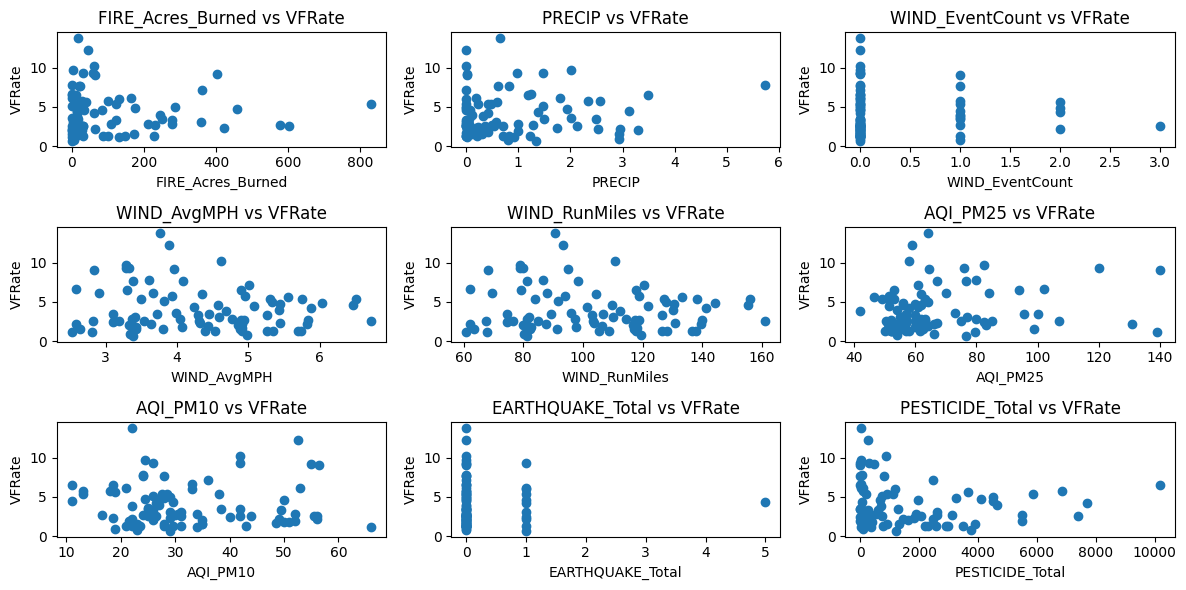

In [5]:
# Prepare features for LSTM
# Exclude 'Year-Month' and 'VFRate' (target variable)
feature_columns = ['FIRE_Acres_Burned', 'PRECIP', 'WIND_EventCount', 'WIND_AvgMPH', 
				  'WIND_RunMiles', 'AQI_PM25', 'AQI_PM10', 'EARTHQUAKE_Total', 'PESTICIDE_Total']

# Create X (features) and y (target)
X = df_fresno[feature_columns].values
y = df_fresno['VFRate'].values

# Plot correlation between features and VFRate
plt.figure(figsize=(12, 6))
for i, feature in enumerate(feature_columns):
	plt.subplot(3, 3, i+1)
	plt.scatter(df_fresno[feature], df_fresno['VFRate'])
	plt.xlabel(feature)
	plt.ylabel('VFRate')
	plt.title(f'{feature} vs VFRate')

plt.tight_layout()
plt.show()


In [6]:
# now what we want to do is loop through each feature and run the LSTM on each feature individually with a list of
# sliding window sizes and see which feature and sliding window size gives us the best performance
sliding_window_sizes = [1, 3, 6, 8, 12]
results = []

# probably need to make a function that preprocesses the "feature vector" for each run, turn into tensors
# test/train split, scale, and then run the LSTM model
def preprocess_data(X, y, feature_index, window_size, test_size=0.2):
  # Select the feature column
  if feature_index is not None:
    X_feature = X[:, feature_index].reshape(-1, 1)
  else:
    X_feature = X # its the whole feautre set

  # Create sequences for LSTM
  X_sequences, y_sequences = [], []
  for i in range(len(X_feature) - window_size):
    X_sequences.append(X_feature[i:i+window_size])
    y_sequences.append(y[i+window_size])

  X_sequences = np.array(X_sequences)
  y_sequences = np.array(y_sequences)

  # Train-test split
  split_index = int(len(X_sequences) * (1 - test_size))
  X_train, X_test = X_sequences[:split_index], X_sequences[split_index:]
  y_train, y_test = y_sequences[:split_index], y_sequences[split_index:]

  return X_train, X_test, y_train, y_test 

# before we plug into the lstm we need minmax scaling too
from sklearn.preprocessing import MinMaxScaler
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

def scale_data(X_train, X_test, y_train, y_test):
  # Reshape for scaling
  num_samples, window_size, num_features = X_train.shape
  X_train_reshaped = X_train.reshape(-1, num_features)
  X_test_reshaped = X_test.reshape(-1, num_features)

  # Scale features
  X_train_scaled = scaler_X.fit_transform(X_train_reshaped).reshape(num_samples, window_size, num_features)
  X_test_scaled = scaler_X.transform(X_test_reshaped).reshape(X_test.shape[0], window_size, num_features)

  # Scale target
  y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1)).flatten()
  y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1)).flatten()

  return X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled

# below are model parameters 
# model parameters
# lookback has been removed because we are varying the sliding window size
hidden_size          = 32
num_layers           = 2
dropout              = 0.2
learning_rate        = 0.001
epochs               = 300
weight_decay         = 1e-5


In [7]:
# below is my training function for you to utilize 
import torch 
import numpy as np
import matplotlib.pyplot as plt 
from datetime import date

# Creating a Trainer Class to contain Training/Testing/Visualizing
class TrainerNewNew:
  """
  Trainer Class: A class that contains the training, testing, and visualization functions.
  """
  def __init__(self, model, criterion, optimizer, scaler):
    """
    Initialize the class. Takes in a model, crtierion for loss, optimizer, scaler.
    
    Inputs:
      - Model: Neural Network model
      - Criterion: Loss function (Typically MSELoss for time series, may look into more)
      - Optimizer: Optimizer with learning rate added. Typically using Adam
      - Scaler: MinMaxScaler scaler value, used for inverse transform to get actual data back
    """
    self.model     = model 
    self.criterion = criterion 
    self.optimizer = optimizer
    self.scaler    = scaler
  
  def train(self, X_train, y_train, X_test, y_test, epochs):
    history = {'train_loss': [], 'test_loss': []}

    for epoch in range(epochs):
        self.model.train()
        output = self.model(X_train)
        loss = self.criterion(output, y_train)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        
        history['train_loss'].append(loss.item())
        
        if epoch % 10 == 0:
            self.model.eval()
            with torch.no_grad():
                val_loss = self.criterion(self.model(X_test), y_test)
                history['test_loss'].append(val_loss.item())
                print(f"Epoch {epoch+1}/{epochs} - Training Loss {loss.item():.4f}, Testing Loss {val_loss.item():.4f}")
    
    # Capture the final training predictions
    self.model.eval()
    with torch.no_grad():
        final_train_preds = self.model(X_train).detach().cpu().numpy()
        
    # Also inverse transform the training data for later plotting
    y_train_true = self.scaler.inverse_transform(y_train.cpu().numpy().reshape(-1, 1)).flatten()
    final_train_preds_inv = self.scaler.inverse_transform(final_train_preds).flatten()
    
    return history, final_train_preds_inv, y_train_true
    
  def evaluate(self, X_test, y_test):
    """
    Evaluation Loop. Evaluates the model and generates predictions.

    Inputs:
      - X_test: Test matrix X
      - y_test: Test target vector y
    
    Outputs:
      - y_pred: predicted target vector from the model using X_test
      - y_true: True target vector (y_test)
    """
    self.model.eval()
    with torch.no_grad():
        preds = self.model(X_test).detach().cpu().numpy()

        # Inverse transform the predictions using the y_scaler
        # The y_scaler was fit on a 1-D array, so the predictions should be reshaped
        vf_pred = self.scaler.inverse_transform(preds)

        # Inverse transform the true values using the y_scaler
        # The y_scaler was fit on a 1-D array, so the true values should be reshaped
        vf_true = self.scaler.inverse_transform(y_test.cpu().numpy())
        
    return vf_pred.flatten(), vf_true.flatten()
  
  def visualize_results(self, true, pred, county_name="", model_type = "LSTM", title_text = "", show_plot = True, save_fig = False):
    """
    Function to visualize the prediction vs true (test) vector

    Inputs:
      - True: True data (test or validation target vector)
      - Pred: Prediction data from the model evaluation function
    """
    if show_plot:
      plt.figure(figsize=(12, 6))
      plt.plot(true, label="True Values")
      plt.plot(pred[1:], label = "Predicted Values", linestyle="--")
      plt.title(f"{county_name} {model_type} {title_text} True vs Predicted Valley Fever Case Rates")
      plt.xlabel("Months")
      plt.ylabel("Case Rates")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      plt.show()
    
    if save_fig:
      plt.figure(figsize=(12, 6))
      plt.plot(true, label="True Values")
      plt.plot(pred[1:], label = "Predicted Values", linestyle="--")
      plt.title(f"{county_name} {model_type} {title_text} LSTM True vs Predicted Valley Fever Case Rates")
      plt.xlabel("Months")
      plt.ylabel("Case Rates")
      plt.legend()
      plt.grid(True)
      plt.tight_layout()
      img_str = f"Project/plots/{model_type}/{county_name}_{title_text}_plot_{date.today()}.png"
      plt.savefig(img_str)

In [8]:
from loss_functions import RMSELoss
import torch.optim as optim 

criterion = RMSELoss()

In [9]:
# now loop through each feature and sliding window size
for feature_index, feature in enumerate(feature_columns):
  # generate the feature vector and target vector
  for window_size in sliding_window_sizes:
    X_train, X_test, y_train, y_test = preprocess_data(X, y, feature_index, window_size)
    
    # scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale_data(X_train, X_test, y_train, y_test)
    
    # Convert to PyTorch tensors and reshape for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    y_test_tensor  = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1)

    # Initialize the model
    model = LSTM(input_size=1, hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    # Create Trainer instance
    trainer = TrainerNewNew(model, criterion, optimizer, scaler_y)
    
    # Train the model
    history, train_preds_inv, y_train_true = trainer.train(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs)
    
    # Evaluate the model
    y_pred_inv, y_true_inv = trainer.evaluate(X_test_tensor, y_test_tensor)
    
    # Calculate RMSE for test set
    rmse = np.sqrt(np.mean((y_pred_inv - y_true_inv) ** 2))
    
    # Store results
    results.append({
        'feature': feature,
        'window_size': window_size,
        'rmse': rmse
    })
    
    print(f"Feature: {feature}, Window Size: {window_size}, Test RMSE: {rmse:.4f}")
    
    # Optionally visualize results for each run
    #trainer.visualize_results(y_true_inv, y_pred_inv, county_name="Fresno", model_type="LSTM", title_text=f"{feature} Window {window_size}", show_plot=True, save_fig=False)

Epoch 1/300 - Training Loss 0.3831, Testing Loss 0.1398
Epoch 11/300 - Training Loss 0.3520, Testing Loss 0.1099
Epoch 21/300 - Training Loss 0.3198, Testing Loss 0.0855
Epoch 31/300 - Training Loss 0.2858, Testing Loss 0.0789
Epoch 41/300 - Training Loss 0.2513, Testing Loss 0.1068
Epoch 51/300 - Training Loss 0.2231, Testing Loss 0.1634
Epoch 61/300 - Training Loss 0.2157, Testing Loss 0.2197
Epoch 71/300 - Training Loss 0.2186, Testing Loss 0.2318
Epoch 81/300 - Training Loss 0.2161, Testing Loss 0.2128
Epoch 91/300 - Training Loss 0.2156, Testing Loss 0.2016
Epoch 101/300 - Training Loss 0.2156, Testing Loss 0.2041
Epoch 111/300 - Training Loss 0.2151, Testing Loss 0.2088
Epoch 121/300 - Training Loss 0.2171, Testing Loss 0.2098
Epoch 131/300 - Training Loss 0.2133, Testing Loss 0.2076
Epoch 141/300 - Training Loss 0.2166, Testing Loss 0.2067
Epoch 151/300 - Training Loss 0.2161, Testing Loss 0.2072
Epoch 161/300 - Training Loss 0.2171, Testing Loss 0.2072
Epoch 171/300 - Training 

(87, 9)
Epoch 1/300 - Training Loss 0.3347, Testing Loss 0.0952
Epoch 11/300 - Training Loss 0.2993, Testing Loss 0.0780
Epoch 21/300 - Training Loss 0.2647, Testing Loss 0.0921
Epoch 31/300 - Training Loss 0.2315, Testing Loss 0.1417
Epoch 41/300 - Training Loss 0.2180, Testing Loss 0.2043
Epoch 51/300 - Training Loss 0.2172, Testing Loss 0.2229
Epoch 61/300 - Training Loss 0.2229, Testing Loss 0.2048
Epoch 71/300 - Training Loss 0.2171, Testing Loss 0.1961
Epoch 81/300 - Training Loss 0.2177, Testing Loss 0.2020
Epoch 91/300 - Training Loss 0.2159, Testing Loss 0.2089
Epoch 101/300 - Training Loss 0.2167, Testing Loss 0.2099
Epoch 111/300 - Training Loss 0.2146, Testing Loss 0.2072
Epoch 121/300 - Training Loss 0.2141, Testing Loss 0.2094
Epoch 131/300 - Training Loss 0.2162, Testing Loss 0.2119
Epoch 141/300 - Training Loss 0.2135, Testing Loss 0.2117
Epoch 151/300 - Training Loss 0.2144, Testing Loss 0.2125
Epoch 161/300 - Training Loss 0.2110, Testing Loss 0.2132
Epoch 171/300 - T

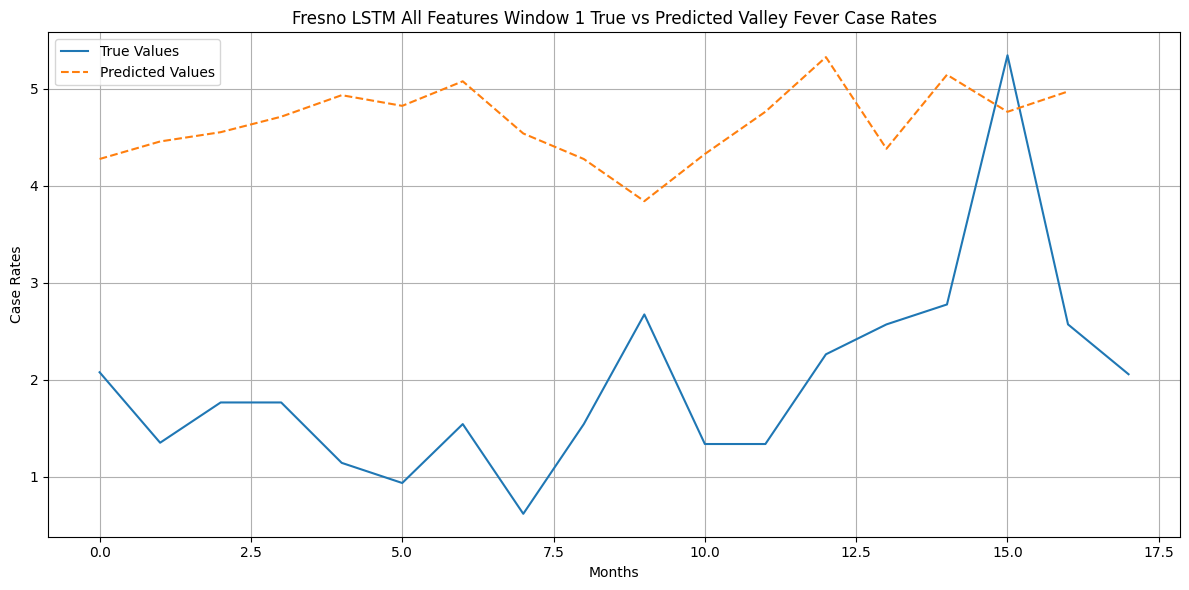

Epoch 1/300 - Training Loss 0.2804, Testing Loss 0.0848
Epoch 11/300 - Training Loss 0.2316, Testing Loss 0.1443
Epoch 21/300 - Training Loss 0.2172, Testing Loss 0.2234
Epoch 31/300 - Training Loss 0.2190, Testing Loss 0.2265
Epoch 41/300 - Training Loss 0.2166, Testing Loss 0.1988
Epoch 51/300 - Training Loss 0.2154, Testing Loss 0.2022
Epoch 61/300 - Training Loss 0.2153, Testing Loss 0.2151
Epoch 71/300 - Training Loss 0.2124, Testing Loss 0.2099
Epoch 81/300 - Training Loss 0.2073, Testing Loss 0.2109
Epoch 91/300 - Training Loss 0.2056, Testing Loss 0.2128
Epoch 101/300 - Training Loss 0.2001, Testing Loss 0.2204
Epoch 111/300 - Training Loss 0.1938, Testing Loss 0.2158
Epoch 121/300 - Training Loss 0.1901, Testing Loss 0.2062
Epoch 131/300 - Training Loss 0.1871, Testing Loss 0.2054
Epoch 141/300 - Training Loss 0.1917, Testing Loss 0.1962
Epoch 151/300 - Training Loss 0.1876, Testing Loss 0.1949
Epoch 161/300 - Training Loss 0.1837, Testing Loss 0.1986
Epoch 171/300 - Training 

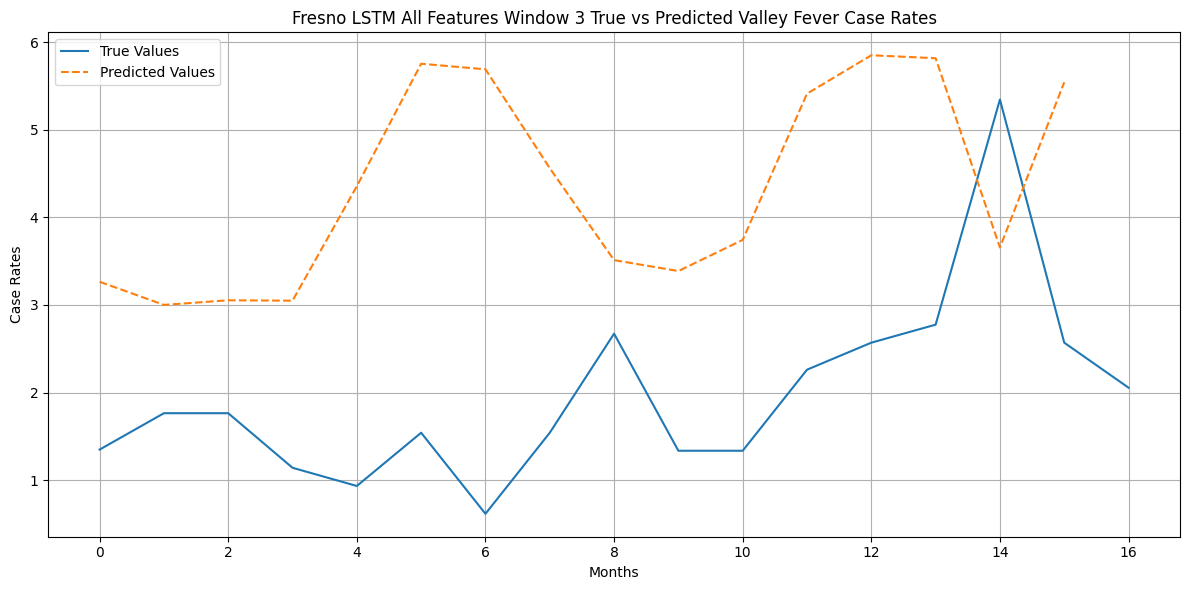

Epoch 1/300 - Training Loss 0.3377, Testing Loss 0.0949
Epoch 11/300 - Training Loss 0.2418, Testing Loss 0.1377
Epoch 21/300 - Training Loss 0.2298, Testing Loss 0.2581
Epoch 31/300 - Training Loss 0.2207, Testing Loss 0.1843
Epoch 41/300 - Training Loss 0.2177, Testing Loss 0.1911
Epoch 51/300 - Training Loss 0.2221, Testing Loss 0.2151
Epoch 61/300 - Training Loss 0.2152, Testing Loss 0.1966
Epoch 71/300 - Training Loss 0.2089, Testing Loss 0.2052
Epoch 81/300 - Training Loss 0.2038, Testing Loss 0.1987
Epoch 91/300 - Training Loss 0.1957, Testing Loss 0.1968
Epoch 101/300 - Training Loss 0.1900, Testing Loss 0.1897
Epoch 111/300 - Training Loss 0.1695, Testing Loss 0.1898
Epoch 121/300 - Training Loss 0.1547, Testing Loss 0.1606
Epoch 131/300 - Training Loss 0.1482, Testing Loss 0.1396
Epoch 141/300 - Training Loss 0.1407, Testing Loss 0.1548
Epoch 151/300 - Training Loss 0.1299, Testing Loss 0.1348
Epoch 161/300 - Training Loss 0.1338, Testing Loss 0.1307
Epoch 171/300 - Training 

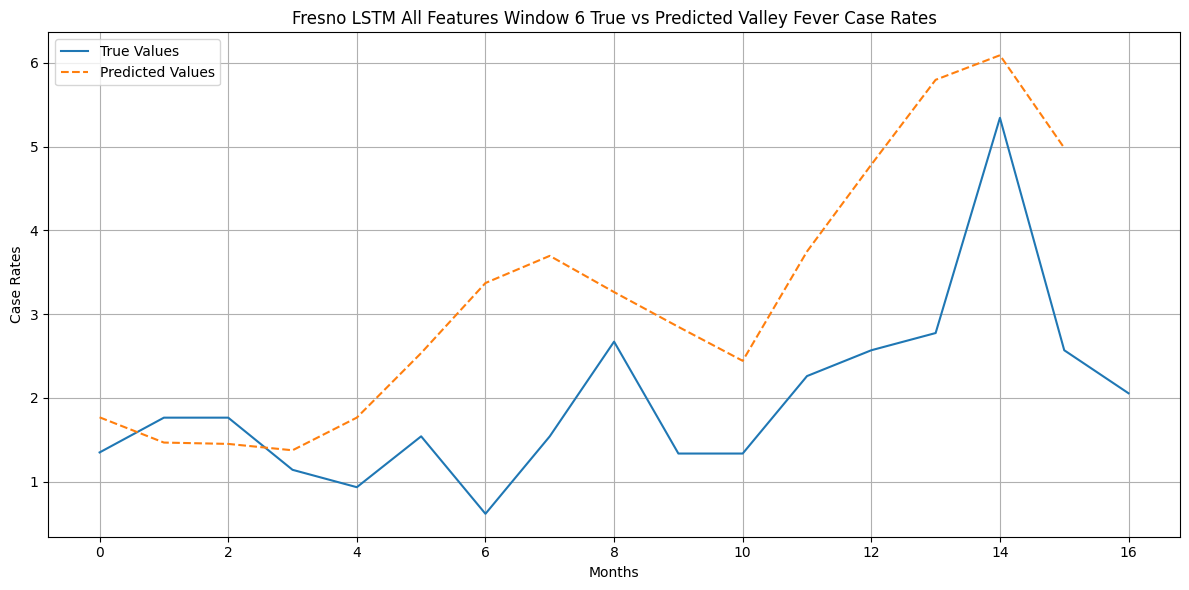

Epoch 1/300 - Training Loss 0.4488, Testing Loss 0.2094
Epoch 11/300 - Training Loss 0.3083, Testing Loss 0.0787
Epoch 21/300 - Training Loss 0.2329, Testing Loss 0.2576
Epoch 31/300 - Training Loss 0.2179, Testing Loss 0.1805
Epoch 41/300 - Training Loss 0.2240, Testing Loss 0.1650
Epoch 51/300 - Training Loss 0.2239, Testing Loss 0.2041
Epoch 61/300 - Training Loss 0.2190, Testing Loss 0.1839
Epoch 71/300 - Training Loss 0.2134, Testing Loss 0.1874
Epoch 81/300 - Training Loss 0.2118, Testing Loss 0.1853
Epoch 91/300 - Training Loss 0.1996, Testing Loss 0.1824
Epoch 101/300 - Training Loss 0.1887, Testing Loss 0.1708
Epoch 111/300 - Training Loss 0.1782, Testing Loss 0.1501
Epoch 121/300 - Training Loss 0.1555, Testing Loss 0.1541
Epoch 131/300 - Training Loss 0.1504, Testing Loss 0.1347
Epoch 141/300 - Training Loss 0.1462, Testing Loss 0.1242
Epoch 151/300 - Training Loss 0.1369, Testing Loss 0.1384
Epoch 161/300 - Training Loss 0.1310, Testing Loss 0.1475
Epoch 171/300 - Training 

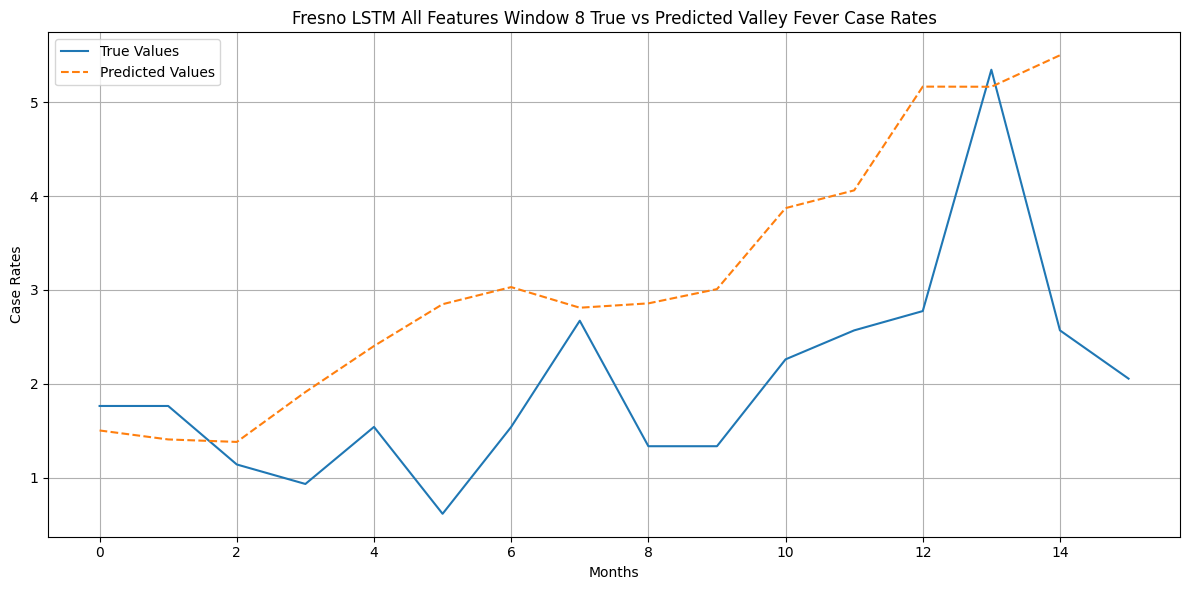

Epoch 1/300 - Training Loss 0.2542, Testing Loss 0.1221
Epoch 11/300 - Training Loss 0.2352, Testing Loss 0.2224
Epoch 21/300 - Training Loss 0.2294, Testing Loss 0.1778
Epoch 31/300 - Training Loss 0.2275, Testing Loss 0.1872
Epoch 41/300 - Training Loss 0.2252, Testing Loss 0.1902
Epoch 51/300 - Training Loss 0.2170, Testing Loss 0.1797
Epoch 61/300 - Training Loss 0.1875, Testing Loss 0.1287
Epoch 71/300 - Training Loss 0.1602, Testing Loss 0.0792
Epoch 81/300 - Training Loss 0.1516, Testing Loss 0.0806
Epoch 91/300 - Training Loss 0.1374, Testing Loss 0.0722
Epoch 101/300 - Training Loss 0.1270, Testing Loss 0.0722
Epoch 111/300 - Training Loss 0.1061, Testing Loss 0.0743
Epoch 121/300 - Training Loss 0.0856, Testing Loss 0.0720
Epoch 131/300 - Training Loss 0.0853, Testing Loss 0.0719
Epoch 141/300 - Training Loss 0.0787, Testing Loss 0.0779
Epoch 151/300 - Training Loss 0.0779, Testing Loss 0.0711
Epoch 161/300 - Training Loss 0.0799, Testing Loss 0.0728
Epoch 171/300 - Training 

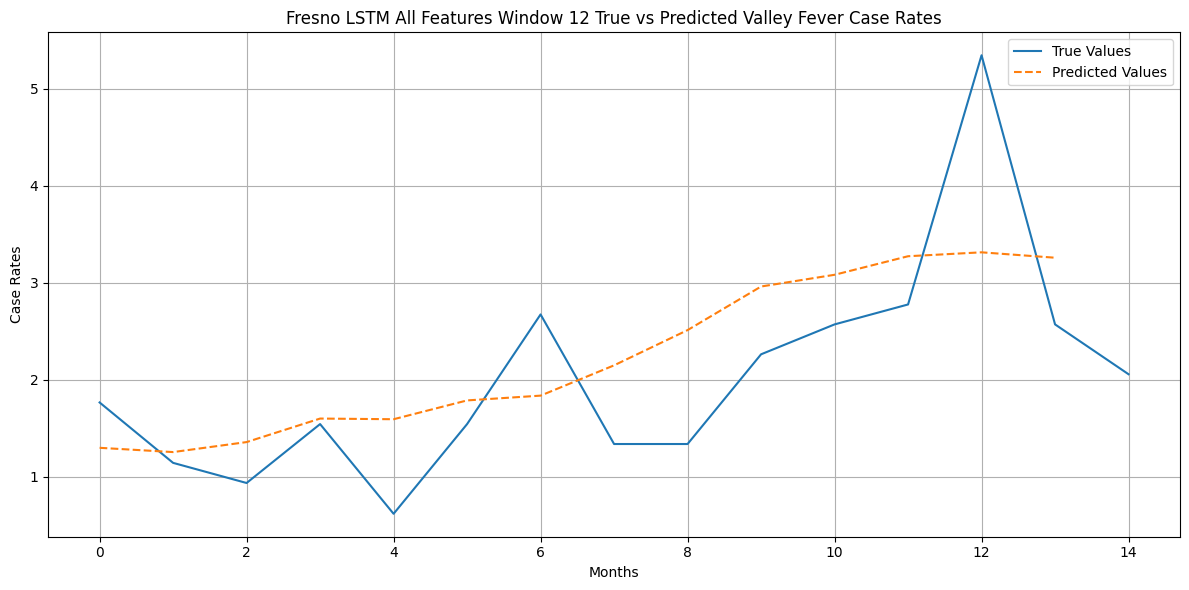

In [10]:
# using the code above, lets run the LSTM model on the full feature vector X with the sliding window varying
# vary the window size as well here
window_size = [1, 2, 4, 6, 8, 12] # change the index to vary the window size
# prep the data using the function you made 
print(X.shape)
for window_size in sliding_window_sizes:
    X_train, X_test, y_train, y_test = preprocess_data(X, y, feature_index=None, window_size=window_size)
    # scale the data
    X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = scale_data(X_train, X_test, y_train, y_test)
    # Convert to PyTorch tensors and reshape for LSTM input
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
    X_test_tensor  = torch.tensor(X_test_scaled, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32).view(-1, 1)
    y_test_tensor  = torch.tensor(y_test_scaled, dtype=torch.float32).view(-1, 1) 
    # Initialize the model
    model = LSTM(input_size=len(feature_columns), hidden_size=hidden_size, num_layers=num_layers, dropout=dropout)
    # Define optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    # Create Trainer instance
    trainer = TrainerNewNew(model, criterion, optimizer, scaler_y)
    # Train the model
    history, train_preds_inv, y_train_true = trainer.train(X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, epochs)
    # Evaluate the model
    y_pred_inv, y_true_inv = trainer.evaluate(X_test_tensor, y_test_tensor)
    # Calculate RMSE for test set
    rmse = np.sqrt(np.mean((y_pred_inv - y_true_inv) ** 2))
    # Store results
    results.append({
        'feature': 'All Features',
        'window_size': window_size,
        'rmse': rmse
    })  

    # visualize the output
    trainer.visualize_results(y_true_inv, y_pred_inv, county_name="Fresno", model_type="LSTM", title_text=f"All Features Window {window_size}", show_plot=True, save_fig=False) 

In [11]:
results_df = pd.DataFrame(results)
results_df

,feature,window_size,rmse
0,FIRE_Acres_Burned,1,2.677248
1,FIRE_Acres_Burned,3,2.331903
2,FIRE_Acres_Burned,6,1.746773
3,FIRE_Acres_Burned,8,1.648524
4,FIRE_Acres_Burned,12,1.294266
5,PRECIP,1,2.748096
6,PRECIP,3,2.786807
7,PRECIP,6,2.606869
8,PRECIP,8,2.091493
9,PRECIP,12,0.989314


In [12]:
# save this data frame as a csv 
results_df.to_csv("../../data/fresno_lstm_feature_window_results.csv", index=False)

In [13]:
# for each feature, what is the sliding window that has the lowest RMSE?
best_results = results_df.loc[results_df.groupby('feature')['rmse'].idxmin()]
best_results

,feature,window_size,rmse
34,AQI_PM10,12,1.599959
25,AQI_PM25,1,2.685788
49,All Features,12,0.798121
39,EARTHQUAKE_Total,12,2.171589
4,FIRE_Acres_Burned,12,1.294266
44,PESTICIDE_Total,12,2.156630
9,PRECIP,12,0.989314
19,WIND_AvgMPH,12,2.094477
14,WIND_EventCount,12,2.259281
23,WIND_RunMiles,8,2.463812


In [14]:
# save this as a csv as well
best_results.to_csv("../../data/fresno_lstm_best_feature_window_results.csv", index=False)

# Creating custom length feature vectors with individual sliding windows

In [15]:
best_results

,feature,window_size,rmse
34,AQI_PM10,12,1.599959
25,AQI_PM25,1,2.685788
49,All Features,12,0.798121
39,EARTHQUAKE_Total,12,2.171589
4,FIRE_Acres_Burned,12,1.294266
44,PESTICIDE_Total,12,2.156630
9,PRECIP,12,0.989314
19,WIND_AvgMPH,12,2.094477
14,WIND_EventCount,12,2.259281
23,WIND_RunMiles,8,2.463812


In [27]:
# first, grab the max window length
max_seq_length = max(best_results["window_size"])
print(f"The maximum window size is {max_seq_length}")

The maximum window size is 12


In [32]:
def grab_window_size_per_feature(best_results: pd.DataFrame, feature:str) -> int:
    feat_window_size:int = best_results.loc[best_results["feature"] == feature, "window_size"].iloc[0]
    return feat_window_size

feature_str : str = "WIND_RunMiles"
print(f"The window size for {feature_str} is {grab_window_size_per_feature(best_results, feature_str)}") 

The window size for WIND_RunMiles is 8
